In [6]:
import os
import pandas as pd
from transformers import LlamaTokenizerFast, BertTokenizerFast, AutoTokenizer
from tqdm import tqdm
from datasets import load_dataset
from dotenv import load_dotenv
from anthropic import Anthropic

#llama_tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B-Instruct")
# tokenizer_bloom = AutoTokenizer.from_pretrained("bigscience/bloom-560m")
# tokenizer_Bert = BertTokenizerFast.from_pretrained("google-bert/bert-base-uncased")

load_dotenv()
client = Anthropic(api_key=os.getenv('ANTHROPIC_API_KEY'))

Tokenizer by language

In [9]:
def calculate_corpus_fertility_anthropic(dataset_name, language_code, client, split='dev', max_docs=10000):
    """
    Calculate fertility for a dataset using Anthropic's API for token counting.
    """
    # Load dataset
    dataset = load_dataset(dataset_name, language_code, split=split)

    total_tokens = 0
    total_words = 0

    # Process up to max_docs
    for i, example in enumerate(tqdm(dataset, desc=f"Calculating fertility for {language_code}")):
        if i >= max_docs:
            break

        # Combine all text fields
        question = example["question"]
        choices = " ".join(eval(example["choices"]))
        answer = example["answer"]
        combined_text = f"{question} {choices} {answer}"

        # Count tokens using Anthropic API
        messages = [{"role": "user", "content": combined_text}]
        token_count_obj = client.messages.count_tokens(
            messages=messages,
            model="claude-3-sonnet-20240229"
        )
        total_tokens += token_count_obj.input_tokens  # Changed from .tokens to .input_tokens

        # Count words using whitespace splitting
        total_words += len(combined_text.split())

    # Compute fertility
    if total_words == 0:
        raise ValueError("Total words in the dataset is zero. Cannot compute fertility.")

    fertility = total_tokens / total_words
    return fertility

# Example usage
dataset_name = "masakhane/afrimmlu"
language_code = "eng"
split = "dev"

fertility_score = calculate_corpus_fertility_anthropic(
    dataset_name, 
    language_code, 
    client, 
    split=split
)
print(fertility_score)

Calculating fertility for eng: 100%|██████████| 25/25 [00:03<00:00,  7.35it/s]

1.4647435897435896


In [ ]:
import os
import pandas as pd
import re

def extract_llm_answer(value):
    """Extract the first letter (answer) from a TextBlock representation."""
    try:
        # Use regex to capture the first letter from TextBlock(text='A)...')
        match = re.search(r"TextBlock\(text='([A-D])\)", value)
        return match.group(1) if match else ""
    except TypeError:
        return ""

input_path = "/sonnet35/"
output_path = "/sonnet35/accuracy/"

os.makedirs(output_path, exist_ok=True)
for file_name in os.listdir(input_path):
    if file_name.endswith(".csv"):
        try:
            file_path = os.path.join(input_path, file_name)
            
            # Read the file with tab as delimiter
            df = pd.read_csv(file_path, sep='\t', on_bad_lines="skip")

            # Normalize column names (strip spaces and lowercase)
            df.columns = df.columns.str.strip().str.lower()

            # Ensure required columns exist
            if 'answer' not in df.columns or 'llm' not in df.columns:
                print(f"Skipping {file_name}: Missing required columns.")
                continue

            # Extract llm_answer from the llm column
            df['llm_answer'] = df['llm'].apply(extract_llm_answer)

            # Add accuracy column as 0 or 1
            df['accuracy'] = (df['llm_answer'] == df['answer']).astype(int)

            # Save updated file
            new_file_name = file_name.split(".")[0] + "_accuracy.csv"
            new_file_path = os.path.join(output_path, new_file_name)
            df.to_csv(new_file_path, index=False)

            print(f"Processed: {file_name}")
        except Exception as e:
            print(f"Error processing {file_name}: {e}")


Processed: orm.csv
Processed: xho.csv
Processed: sot.csv
Processed: swa.csv
Processed: sna.csv
Processed: fra.csv
Processed: zul.csv
Processed: lin.csv
Processed: ibo.csv
Processed: twi.csv
Processed: amh.csv
Processed: eng.csv
Processed: ewe.csv
Processed: wol.csv
Processed: hau.csv
Processed: yor.csv
Processed: lug.csv
Processed: kin.csv


In [30]:
import pandas as pd
# List all the accuracy CSV files
accuracy_files = [f for f in os.listdir(output_path) if f.endswith('_accuracy.csv')]

# Initialize a list to hold individual DataFrames
dfs = []

# Loop through each CSV file and load it into a DataFrame
for accuracy_file in accuracy_files:
    file_path = os.path.join(output_path, accuracy_file)
    try:
        # Load the CSV into a DataFrame
        df = pd.read_csv(file_path)
        
        # Add a column to the DataFrame for the file name (language)
        df['language'] = accuracy_file.replace('_accuracy.csv', '')  # Remove '_accuracy.csv' to get the language name
        
        # Add the DataFrame to the list
        dfs.append(df)
    except Exception as e:
        print(f"Error loading {accuracy_file}: {e}")

# Concatenate all DataFrames into one
combined_df = pd.concat(dfs, ignore_index=True)

# Display the resulting DataFrame
(combined_df)

,question,choices,answer,subject,llm,prompt,llm_answer,accuracy,language
0,በ 24 = 2p ውስጥ የ p ዋጋ ስንት ነው,"['p = 5', 'p = 9', 'p = 13', 'p = 25']",C,elementary_mathematics,"[TextBlock(text='C)p = 13', type='text')]","[{'role': 'user', 'content': [{'type': 'text',...",C,1,amh
1,ወይዘሮ ፔሬዝ በ5 ቀናት ውስጥ በአጠቃላይ 40 ማይል ነድታለች። በየቀኑ ...,"['5', '7', '8', '9']",C,elementary_mathematics,[TextBlock(text='C) 8\n\nTo find the daily mil...,"[{'role': 'user', 'content': [{'type': 'text',...",C,1,amh
2,የ −40 ÷ (−8) ድርሻ ፈልጉ,"['1 ሲካፈል 5', '-5', '−1 ሲካፈል 5', '5']",D,elementary_mathematics,[TextBlock(text='B) -5\n\nThe correct answer i...,"[{'role': 'user', 'content': [{'type': 'text',...",B,0,amh
3,የእግር ኳስ ቡድን የእግር ኳስ ኳሶችን ለመግዛት $90.00 አለው። አንድ...,"['4', '5', '6', '7']",B,elementary_mathematics,"[TextBlock(text=""B) 5\n\nTo find the maximum n...","[{'role': 'user', 'content': [{'type': 'text',...",NaN,0,amh
4,አንተ እና ሶስት ጓደኞች ወደ ኮንሰርት ሄዳችሁ። የአራት ትኬቶች አጠቃላይ...,"['4t = 112; $449', '4t = 112; $29', 't over 4 ...",B,elementary_mathematics,[TextBlock(text='B) 4t = 112; $28\n\nThe equat...,"[{'role': 'user', 'content': [{'type': 'text',...",B,1,amh
...,...,...,...,...,...,...,...,...,...
8995,Ho fokotswa ha meputso e fokolang tlhahisong y...,['sehlahiswa se tlwaelehileng sa mosebetsi se ...,D,high_school_microeconomics,[TextBlock(text='B) Kakaretso ya ho etsa sehla...,"[{'role': 'user', 'content': [{'type': 'text',...",B,0,sot
8996,Seo o se telang ho tswellisa tsela e nngwe e b...,"['tjhelete.', 'lefatshe', 'ditjeho tsa tjhelet...",D,high_school_microeconomics,"[TextBlock(text='B) lefatshe', type='text')]","[{'role': 'user', 'content': [{'type': 'text',...",B,0,sot
8997,Ke efe ho tse latelang e senang tshobotsi ya i...,"['Ho kena mahala indastering.', 'Product diffe...",B,high_school_microeconomics,[TextBlock(text='B) Product differentiation\n\...,"[{'role': 'user', 'content': [{'type': 'text',...",B,1,sot
8998,E amana le mmaraka wa basebetsi o nang le more...,"['e lefa hanyane mme e hira haholo', 'e lefa h...",D,high_school_microeconomics,[TextBlock(text='B) e lefa hanyane ebe e hira ...,"[{'role': 'user', 'content': [{'type': 'text',...",B,0,sot


In [31]:
combined_df.groupby(['language']).agg(
    mean_accuracy=('accuracy', 'mean'))

,mean_accuracy
language,
amh,0.612
eng,0.678
ewe,0.358
fra,0.500
hau,0.402
ibo,0.396
kin,0.326
lin,0.470
lug,0.286


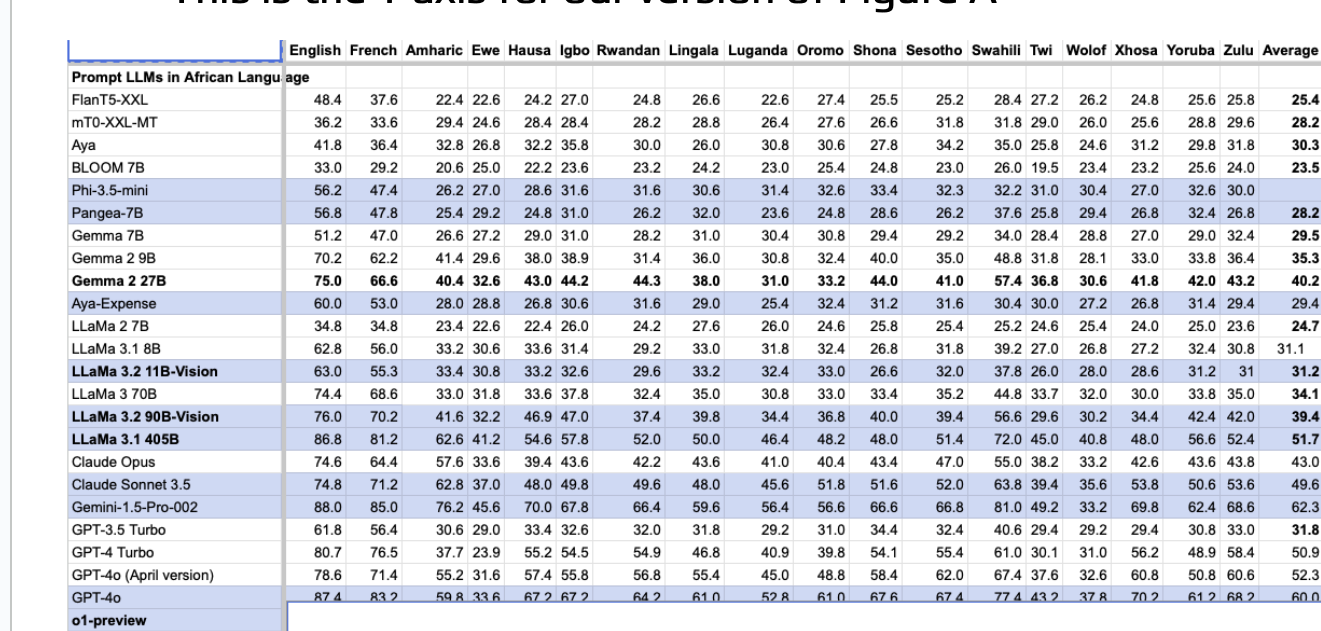

In [34]:
from collections import defaultdict
from datasets import load_dataset
from tqdm import tqdm

def calculate_fertility_by_subject_anthropic(
    dataset_name,
    language_code,
    client,
    split='dev',
    max_docs=10000,
    model_name="claude-3-sonnet-20240229"
):
    """
    Calculate fertility for each subject in the dataset using Anthropic's token counting API.
    Each record's fertility is calculated, then averaged by subject.

    Args:
        dataset_name (str): The dataset to load.
        language_code (str): The specific language code for the dataset.
        client (anthropic.Client): The Anthropic client instance to use for token counting.
        split (str): The split of the dataset to evaluate (default: "dev").
        max_docs (int): Maximum number of documents to evaluate (default: 10,000).
        model_name (str): The Anthropic model to use for token counting (default: "claude-3-sonnet-20240229").

    Returns:
        dict: A dictionary where keys are subjects and values are mean fertility scores for that subject.
    """
    # Load dataset
    dataset = load_dataset(dataset_name, language_code, split=split)

    # Dictionary to store fertility scores by subject
    subject_fertility = defaultdict(list)

    # Process up to max_docs
    for i, example in enumerate(tqdm(dataset, desc=f"Calculating fertility for {language_code}")):
        if i >= max_docs:
            break

        # Combine all text fields
        question = example["question"]
        choices = " ".join(eval(example["choices"]))  # Combine choices into a string
        answer = example["answer"]
        combined_text = f"{question} {choices} {answer}"

        # Get the subject
        subject = example.get("subject", "unknown")  # Default to "unknown" if no subject is provided

        # Count tokens using Anthropic API
        messages = [
            {
                "role": "user",
                "content": combined_text
            }
        ]
        token_count_obj = client.messages.count_tokens(
            messages=messages,
            model=model_name
        )
        total_tokens = token_count_obj.input_tokens

        # Count words using whitespace splitting
        total_words = len(combined_text.split())

        # Calculate fertility for this record
        if total_words > 0:
            record_fertility = total_tokens / total_words
            subject_fertility[subject].append(record_fertility)

    # Compute mean fertility for each subject
    fertility_by_subject = {}
    for subject, fertility_list in subject_fertility.items():
        if fertility_list:
            mean_fertility = sum(fertility_list) / len(fertility_list)
            fertility_by_subject[subject] = mean_fertility
        else:
            fertility_by_subject[subject] = None  # Handle cases with no valid records

    return fertility_by_subject

# Example usage
if __name__ == "__main__":
    # Make sure you have an Anthropic client instantiated as `client`.
    # Example: 
    #   from anthropic import Client
    #   client = Client(api_key="YOUR_ANTHROPIC_API_KEY")
    
    dataset_name = "masakhane/afrimmlu"
    language_code = "amh"  # Example: Amharic
    split = "test"         # Use "train" or any available split

    # Calculate fertility for each subject using the Anthropic API
    fertility_scores = calculate_fertility_by_subject_anthropic(
        dataset_name,
        language_code,
        client,
        split=split
    )

    # Print the fertility scores for each subject
    for subject, fertility in fertility_scores.items():
        print(f"Subject: {subject}, Mean Fertility: {fertility}")

Calculating fertility for amh: 100%|██████████| 500/500 [04:00<00:00,  2.08it/s]

Subject: elementary_mathematics, Mean Fertility: 4.655221115622704
Subject: high_school_geography, Mean Fertility: 6.456467084200093
Subject: international_law, Mean Fertility: 6.204829715904315
Subject: global_facts, Mean Fertility: 5.613975072668583
Subject: high_school_microeconomics, Mean Fertility: 6.504111127447751


In [35]:
languages = {
    "amh": "Amharic",
    "eng": "English",
    "ewe": "Ewe",
    "fra": "French",
    "hau": "Hausa",
    "ibo": "Igbo",
    "kin": "Kinyarwanda",
    "lin": "Lingala",
    "lug": "Luganda",
    "orm": "Oromo",
    "sna": "Shona",
    "sot": "Southern Sotho",
    "swa": "Swahili",
    "twi": "Twi",
    "wol": "Wolof",
    "xho": "Xhosa",
    "yor": "Yoruba",
    "zul": "Zulu",
}

results_anthropic_tokenizer = {}

# Make sure you have an Anthropic client instantiated as `client`.
# Example:
#   from anthropic import Client
#   client = Client(api_key="YOUR_ANTHROPIC_API_KEY")

# Process each language
for lang_code, lang_name in languages.items():
    try:
        print(f"Processing language: {lang_name} ({lang_code})")

        # Calculate fertility for each subject using the updated function
        fertility_scores_by_subject = calculate_fertility_by_subject_anthropic(
            dataset_name="masakhane/afrimmlu",
            language_code=lang_code,
            client=client,
            split='test'  # or 'dev', depending on your needs
        )

        # Store results for this language
        results_anthropic_tokenizer[lang_code] = fertility_scores_by_subject

        # Print the fertility scores for each subject in the language
        print(f"Fertility Scores for {lang_name}:")
        for subject, fertility in fertility_scores_by_subject.items():
            print(f"  {subject}: {fertility}")

    except Exception as e:
        print(f"Failed for {lang_name} ({lang_code}): {e}")

# Print all fertility results by language
print("\nFertility Scores by Language:")
for lang_code, fertility_scores in results_anthropic_tokenizer.items():
    print(f"\n{languages[lang_code]} ({lang_code}):")
    for subject, fertility in fertility_scores.items():
        print(f"  {subject}: {fertility}")

Processing language: Amharic (amh)


Calculating fertility for amh: 100%|██████████| 500/500 [04:00<00:00,  2.08it/s]


Fertility Scores for Amharic:
  elementary_mathematics: 4.655221115622704
  high_school_geography: 6.456467084200093
  international_law: 6.204829715904315
  global_facts: 5.613975072668583
  high_school_microeconomics: 6.504111127447751
Processing language: English (eng)


Calculating fertility for eng: 100%|██████████| 500/500 [04:58<00:00,  1.68it/s]


Fertility Scores for English:
  global_facts: 1.8575151967698371
  international_law: 1.3356384626441982
  high_school_microeconomics: 1.4450216747955205
  high_school_geography: 1.6429125178060202
  elementary_mathematics: 2.1364648298695696
Processing language: Ewe (ewe)


Calculating fertility for ewe: 100%|██████████| 500/500 [04:58<00:00,  1.67it/s]


Fertility Scores for Ewe:
  elementary_mathematics: 3.161848332379317
  high_school_geography: 4.048028991758661
  international_law: 3.8293272310746276
  global_facts: 3.352552191383268
  high_school_microeconomics: 3.567263896677433
Processing language: French (fra)


Calculating fertility for fra: 100%|██████████| 500/500 [04:56<00:00,  1.68it/s]


Fertility Scores for French:
  elementary_mathematics: 2.374683199749252
  high_school_geography: 2.2033310005003446
  international_law: 1.930887139520635
  global_facts: 2.199811343677241
  high_school_microeconomics: 1.9543735770947779
Processing language: Hausa (hau)


Calculating fertility for hau: 100%|██████████| 500/500 [04:58<00:00,  1.68it/s]


Fertility Scores for Hausa:
  elementary_mathematics: 2.843816947802056
  high_school_geography: 2.801808892495653
  international_law: 2.7009566847678332
  global_facts: 2.5989485937989882
  high_school_microeconomics: 2.40932316233429
Processing language: Igbo (ibo)


Calculating fertility for ibo: 100%|██████████| 500/500 [04:57<00:00,  1.68it/s]


Fertility Scores for Igbo:
  elementary_mathematics: 3.357371850688904
  high_school_geography: 3.2989926880327607
  international_law: 3.131062516858652
  global_facts: 3.0659096950289264
  high_school_microeconomics: 3.3795464423653505
Processing language: Kinyarwanda (kin)


Calculating fertility for kin: 100%|██████████| 500/500 [04:57<00:00,  1.68it/s]


Fertility Scores for Kinyarwanda:
  elementary_mathematics: 3.1495489785636583
  high_school_geography: 3.4773355874252547
  international_law: 3.384046170407935
  global_facts: 3.1224342437360497
  high_school_microeconomics: 3.4453187660941746
Processing language: Lingala (lin)


Calculating fertility for lin: 100%|██████████| 500/500 [04:58<00:00,  1.68it/s]


Fertility Scores for Lingala:
  elementary_mathematics: 2.4690481895660157
  high_school_geography: 2.22609102122758
  international_law: 2.0534058463739133
  global_facts: 2.3255190268069286
  high_school_microeconomics: 2.0583037918643443
Processing language: Luganda (lug)


Calculating fertility for lug: 100%|██████████| 500/500 [04:58<00:00,  1.68it/s]


Fertility Scores for Luganda:
  elementary_mathematics: 3.231471310603535
  high_school_geography: 3.880871562884966
  international_law: 3.6955589443181225
  global_facts: 3.2811653539694547
  high_school_microeconomics: 3.7645650564929958
Processing language: Oromo (orm)


Calculating fertility for orm: 100%|██████████| 500/500 [04:58<00:00,  1.68it/s]


Fertility Scores for Oromo:
  elementary_mathematics: 3.323268464994895
  high_school_geography: 3.700021297151904
  international_law: 3.4692383474789805
  global_facts: 3.5131667104137767
  high_school_microeconomics: 3.320626342572426
Processing language: Shona (sna)


Calculating fertility for sna: 100%|██████████| 500/500 [04:58<00:00,  1.68it/s]


Fertility Scores for Shona:
  elementary_mathematics: 3.237981093034845
  high_school_geography: 3.548753436583149
  international_law: 3.41366004019341
  global_facts: 3.5351143849782085
  high_school_microeconomics: 3.586010687606505
Processing language: Southern Sotho (sot)


Calculating fertility for sot: 100%|██████████| 500/500 [04:58<00:00,  1.67it/s]


Fertility Scores for Southern Sotho:
  elementary_mathematics: 2.5926158995419724
  high_school_geography: 2.344908423218838
  international_law: 2.259718210141331
  global_facts: 2.443388900136568
  high_school_microeconomics: 2.3402555654977175
Processing language: Swahili (swa)


Calculating fertility for swa: 100%|██████████| 500/500 [04:58<00:00,  1.67it/s]


Fertility Scores for Swahili:
  elementary_mathematics: 2.779690673003809
  global_facts: 2.865135696607639
  high_school_geography: 2.8436629307160475
  high_school_microeconomics: 2.595500194740923
  international_law: 2.5759650973299797
Processing language: Twi (twi)


Calculating fertility for twi: 100%|██████████| 500/500 [04:58<00:00,  1.68it/s]


Fertility Scores for Twi:
  elementary_mathematics: 3.40552706462953
  high_school_geography: 3.5400562853630206
  international_law: 3.210372819963722
  global_facts: 3.222682705418969
  high_school_microeconomics: 3.1507782491554672
Processing language: Wolof (wol)


Calculating fertility for wol: 100%|██████████| 500/500 [04:58<00:00,  1.68it/s]


Fertility Scores for Wolof:
  elementary_mathematics: 2.5374441167996475
  high_school_geography: 2.421551278001745
  international_law: 2.2973813144068886
  global_facts: 2.4800598837671206
  high_school_microeconomics: 2.252358192132977
Processing language: Xhosa (xho)


Calculating fertility for xho: 100%|██████████| 500/500 [04:57<00:00,  1.68it/s]


Fertility Scores for Xhosa:
  elementary_mathematics: 3.8421804321620203
  high_school_geography: 4.218842278447361
  international_law: 4.149637867187156
  global_facts: 4.442821357197474
  high_school_microeconomics: 3.956619589371472
Processing language: Yoruba (yor)


Calculating fertility for yor: 100%|██████████| 500/500 [04:58<00:00,  1.67it/s]


Fertility Scores for Yoruba:
  elementary_mathematics: 3.7903506266292597
  high_school_geography: 4.832122943999086
  international_law: 4.3423874269506255
  global_facts: 4.298834761041142
  high_school_microeconomics: 4.145022673213099
Processing language: Zulu (zul)


Calculating fertility for zul: 100%|██████████| 500/500 [04:57<00:00,  1.68it/s]

Fertility Scores for Zulu:
  elementary_mathematics: 3.399386397452383
  high_school_geography: 4.1530064250423875
  international_law: 4.080595826717445
  global_facts: 3.9765399042329603
  high_school_microeconomics: 4.076263623867853

Fertility Scores by Language:

Amharic (amh):
  elementary_mathematics: 4.655221115622704
  high_school_geography: 6.456467084200093
  international_law: 6.204829715904315
  global_facts: 5.613975072668583
  high_school_microeconomics: 6.504111127447751

English (eng):
  global_facts: 1.8575151967698371
  international_law: 1.3356384626441982
  high_school_microeconomics: 1.4450216747955205
  high_school_geography: 1.6429125178060202
  elementary_mathematics: 2.1364648298695696

Ewe (ewe):
  elementary_mathematics: 3.161848332379317
  high_school_geography: 4.048028991758661
  international_law: 3.8293272310746276
  global_facts: 3.352552191383268
  high_school_microeconomics: 3.567263896677433

French (fra):
  elementary_mathematics: 2.374683199749252

In [7]:
def map_fertility(row):
    language = row['language']
    subject = row['subject']
    return results_anthropic_tokenizer.get(language, {}).get(subject, None)  # Default to None if not found



# Apply the function to the DataFrame to create a new column 'fertility'
# combined_df['fertility'] = combined_df.apply(map_fertility, axis=1)

combined_df = pd.read_csv('anthropic_per_subject_results.csv')
# Display the updated DataFrame
#combined_df.to_csv('anthropic_per_subject_results.csv', index=False)



In [8]:
aggregated_df = combined_df.groupby(['language', 'subject']).agg(
    mean_accuracy=('accuracy', 'mean'),
    mean_fertility=('fertility', 'mean')
).reset_index()

# Display the aggregated DataFrame
(aggregated_df)

,language,subject,mean_accuracy,mean_fertility
0,amh,elementary_mathematics,0.57,4.655221
1,amh,global_facts,0.56,5.613975
2,amh,high_school_geography,0.59,6.456467
3,amh,high_school_microeconomics,0.59,6.504111
4,amh,international_law,0.75,6.204830
...,...,...,...,...
85,zul,elementary_mathematics,0.54,3.399386
86,zul,global_facts,0.51,3.976540
87,zul,high_school_geography,0.65,4.153006
88,zul,high_school_microeconomics,0.35,4.076264


In [16]:
anthropic_results = {
    'amh': 62.8,   # Amharic
    'eng': 74.8,   # English
    'ewe': 37.0,   # Ewe
    'fra': 71.2,   # French
    'hau': 48.0,   # Hausa
    'ibo': 49.8,   # Igbo
    'kin': 49.6,   # Kinyarwanda
    'lin': 48.0,   # Lingala
    'lug': 45.6,   # Luganda
    'orm': 51.8,   # Oromo
    'sna': 51.6,   # Shona
    'sot': 52.0,   # Southern Sotho
    'swa': 63.8,   # Swahili
    'twi': 39.4,   # Twi
    'wol': 35.6,   # Wolof
    'xho': 53.8,   # Xhosa
    'yor': 50.6,   # Yoruba
    'zul': 53.6    # Zulu
}

In [17]:
grouped_languages = combined_df.groupby(['language']).agg(
    mean_accuracy=('accuracy', 'mean'))
grouped_languages['mean_accuracy'] = grouped_languages['mean_accuracy'] * 100
grouped_languages

,mean_accuracy
language,
amh,61.2
eng,67.8
ewe,35.8
fra,50.0
hau,40.2
ibo,39.6
kin,32.6
lin,47.0
lug,28.6


In [20]:
for language, expected_accuracy in anthropic_results.items():
    try:
        actual_accuracy = grouped_languages.loc[language, 'mean_accuracy']
        difference = abs(actual_accuracy - expected_accuracy)
        
        if difference > 1:
            print(f"Significant difference for {language}: Expected {expected_accuracy}%, but got {actual_accuracy:.1f}%. Difference: {difference:.1f}")
        else:
            print(f"Match for {language}: {actual_accuracy:.1f}% (Difference: {difference:.1f}%)")
    except KeyError:
        print(f"KeyError: '{language}' not found in grouped_languages.")

Significant difference for amh: Expected 62.8%, but got 61.2%. Difference: 1.6
Significant difference for eng: Expected 74.8%, but got 67.8%. Difference: 7.0
Significant difference for ewe: Expected 37.0%, but got 35.8%. Difference: 1.2
Significant difference for fra: Expected 71.2%, but got 50.0%. Difference: 21.2
Significant difference for hau: Expected 48.0%, but got 40.2%. Difference: 7.8
Significant difference for ibo: Expected 49.8%, but got 39.6%. Difference: 10.2
Significant difference for kin: Expected 49.6%, but got 32.6%. Difference: 17.0
Match for lin: 47.0% (Difference: 1.0%)
Significant difference for lug: Expected 45.6%, but got 28.6%. Difference: 17.0
Significant difference for orm: Expected 51.8%, but got 37.4%. Difference: 14.4
Significant difference for sna: Expected 51.6%, but got 50.4%. Difference: 1.2
Significant difference for sot: Expected 52.0%, but got 49.8%. Difference: 2.2
Significant difference for swa: Expected 63.8%, but got 61.8%. Difference: 2.0
Signifi

In [9]:
import pandas as pd
from scipy.stats import pearsonr

# Assuming aggregated_df is already loaded and contains the necessary columns

# Group by 'subject' (language) and calculate Pearson correlation per group
correlations = {}

for language, group in aggregated_df.groupby('language'):
    corr, p_value = pearsonr(group['mean_accuracy'], group['mean_fertility'])
    correlations[language] = {'correlation': corr, 'p_value': p_value}

# Convert results to a DataFrame for easy viewing
correlation_df = pd.DataFrame.from_dict(correlations, orient='index')

print(correlation_df)


     correlation   p_value
amh     0.345411  0.569118
eng    -0.604330  0.280356
ewe    -0.503315  0.387351
fra     0.860208  0.061409
hau     0.451088  0.445778
ibo     0.120498  0.846949
kin    -0.366097  0.544503
lin     0.171560  0.782640
lug    -0.687344  0.199727
orm     0.135783  0.827649
sna    -0.631186  0.253468
sot     0.429884  0.470014
swa    -0.008520  0.989152
twi     0.343324  0.571612
wol     0.549809  0.337034
xho     0.470668  0.423654
yor    -0.635173  0.249539
zul    -0.072758  0.907443


From the MEGA Paper " We report the curves for the cases where the person coefficient |ρ| > 0.7 with a p-value of 0.05. We have combined Indic- XNLI and XNLI for a better coverage of languages.
"

<Figure size 1200x800 with 0 Axes>

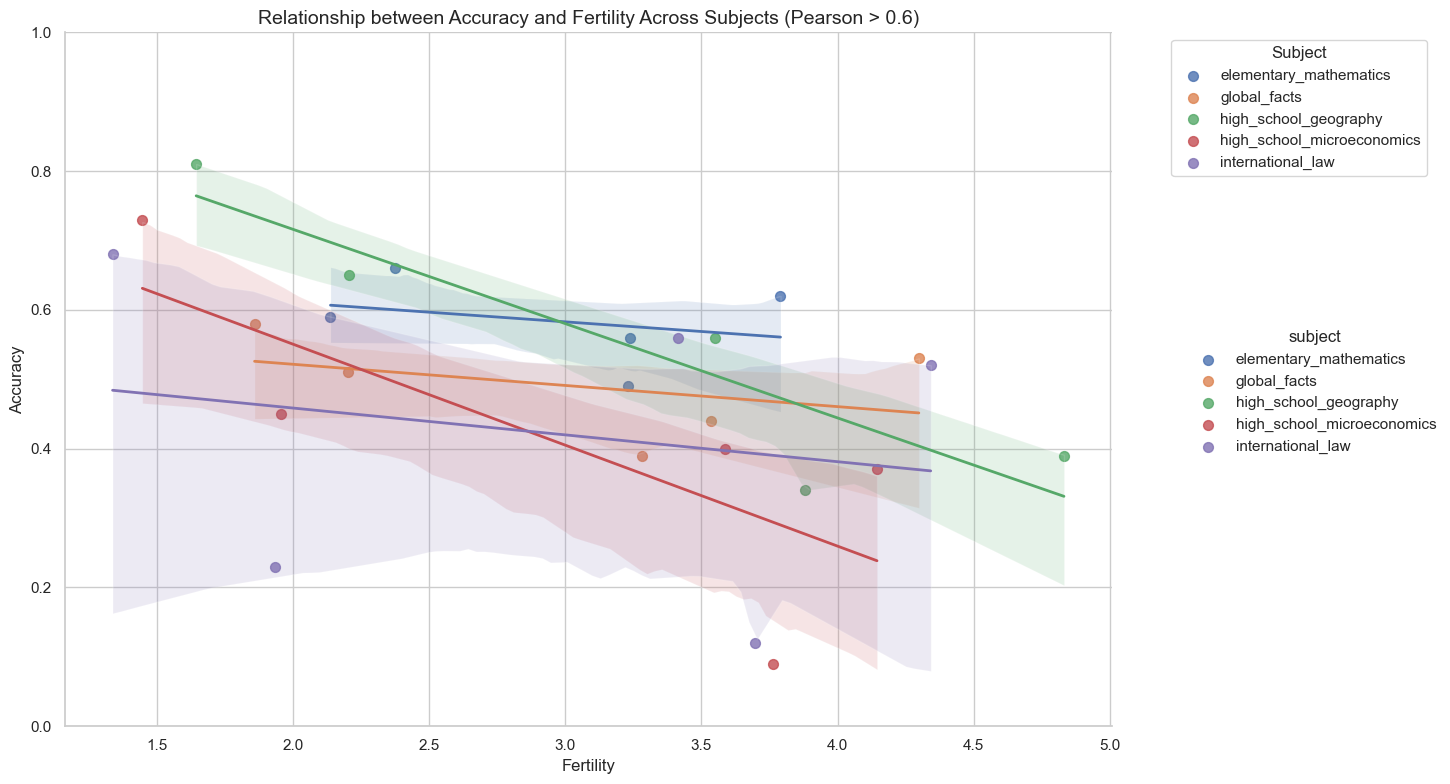

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming correlation_df contains the correlations per language
# Filter languages with Pearson correlation > 0.5
valid_languages = correlation_df[abs(correlation_df['correlation']) > 0.6].index

# Filter the original aggregated_df to include only the valid languages
filtered_df = aggregated_df[aggregated_df['language'].isin(valid_languages)]

# Set up the plot
plt.figure(figsize=(12, 8))
sns.set_theme(style="whitegrid")

# Create the scatterplot with regression lines for each subject
g = sns.lmplot(
    data=filtered_df,  # Use the filtered dataframe
    x="mean_fertility",
    y="mean_accuracy",
    hue="subject",
    height=8,
    aspect=1.5,
    scatter_kws={"s": 50},
    line_kws={"linewidth": 2},
    ci=80,
)

# Customize the plot
plt.title("Relationship between Accuracy and Fertility Across Subjects (Pearson > 0.6)", fontsize=14)
plt.xlabel("Fertility", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.ylim(0,1)
# Adjust legend
plt.legend(title="Subject", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

# Show the plot
plt.show()


In [42]:
print(valid_languages)

Index(['eng', 'fra', 'lug', 'sna', 'yor'], dtype='object')


Parity 

In [43]:
premiums = {}

# Iterate over the languages and their corresponding subjects
for language, subjects in results_anthropic_tokenizer.items():
    premiums[language] = {}
    for subject, value in subjects.items():
        # For each subject, calculate the premium relative to English
        if subject in results_anthropic_tokenizer['eng']:
            premium = value / results_anthropic_tokenizer['eng'][subject]
            premiums[language][subject] = premium

# Display the calculated premiums
(premiums)

{'amh': {'elementary_mathematics': 2.178936461082256,
  'high_school_geography': 3.9298909797231287,
  'international_law': 4.645590771338265,
  'global_facts': 3.022303711125011,
  'high_school_microeconomics': 4.5010474520170245},
 'eng': {'global_facts': 1.0,
  'international_law': 1.0,
  'high_school_microeconomics': 1.0,
  'high_school_geography': 1.0,
  'elementary_mathematics': 1.0},
 'ewe': {'elementary_mathematics': 1.479944012264572,
  'high_school_geography': 2.463934596569076,
  'international_law': 2.8670387520089897,
  'global_facts': 1.8048585536275854,
  'high_school_microeconomics': 2.4686577086687804},
 'fra': {'elementary_mathematics': 1.1115011895113787,
  'high_school_geography': 1.3411127960986742,
  'international_law': 1.4456660193043616,
  'global_facts': 1.184276364200221,
  'high_school_microeconomics': 1.3524873786902427},
 'hau': {'elementary_mathematics': 1.331085308797557,
  'high_school_geography': 1.7053914083248005,
  'international_law': 2.02222140220

In [11]:
def map_parity(row):
    language = row['language']
    subject = row['subject']
    return premiums.get(language, {}).get(subject, None)  # Default to None if not found

# Apply the function to the DataFrame to create a new column 'fertility'
# combined_df['parity'] = combined_df.apply(map_parity, axis=1)
combined_df = pd.read_csv('anthropic_per_subject_results_parity.csv')

# Display the updated DataFrame
# combined_df.to_csv('anthropic_per_subject_results_parity.csv', index=False)


In [12]:
aggregated_df_parity = combined_df.groupby(['language','subject']).agg(
    mean_accuracy=('accuracy', 'mean'),
    mean_parity=('parity', 'mean')
).reset_index()

# Display the aggregated DataFrame
(aggregated_df_parity)

,language,subject,mean_accuracy,mean_parity
0,amh,elementary_mathematics,0.57,2.178936
1,amh,global_facts,0.56,3.022304
2,amh,high_school_geography,0.59,3.929891
3,amh,high_school_microeconomics,0.59,4.501047
4,amh,international_law,0.75,4.645591
...,...,...,...,...
85,zul,elementary_mathematics,0.54,1.591127
86,zul,global_facts,0.51,2.140785
87,zul,high_school_geography,0.65,2.527832
88,zul,high_school_microeconomics,0.35,2.820901


In [13]:
import pandas as pd
from scipy.stats import pearsonr

# Assuming aggregated_df is already loaded and contains the necessary columns

# Group by 'subject' (language) and calculate Pearson correlation per group
correlations = {}

for language, group in aggregated_df_parity.groupby('language'):
    corr, p_value = pearsonr(group['mean_accuracy'], group['mean_parity'])
    correlations[language] = {'correlation': corr, 'p_value': p_value}

# Convert results to a DataFrame for easy viewing
correlation_df = pd.DataFrame.from_dict(correlations, orient='index')

print(correlation_df)


     correlation   p_value
amh     0.634016  0.250677
eng          NaN       NaN
ewe    -0.287561  0.638976
fra    -0.702876  0.185510
hau    -0.855875  0.064242
ibo    -0.927403  0.023223
kin    -0.669231  0.216672
lin    -0.014230  0.981882
lug    -0.928290  0.022802
orm    -0.854114  0.065406
sna    -0.231400  0.708023
sot    -0.707110  0.181687
swa     0.076220  0.903048
twi    -0.645113  0.239817
wol    -0.649886  0.235185
xho     0.347387  0.566758
yor    -0.673749  0.212410
zul    -0.322531  0.596576


/var/folders/86/c2gz31wn29b2r_53d_q3g3hc0000gn/T/ipykernel_89496/122986206.py:10: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, p_value = pearsonr(group['mean_accuracy'], group['mean_parity'])


<Figure size 1200x800 with 0 Axes>

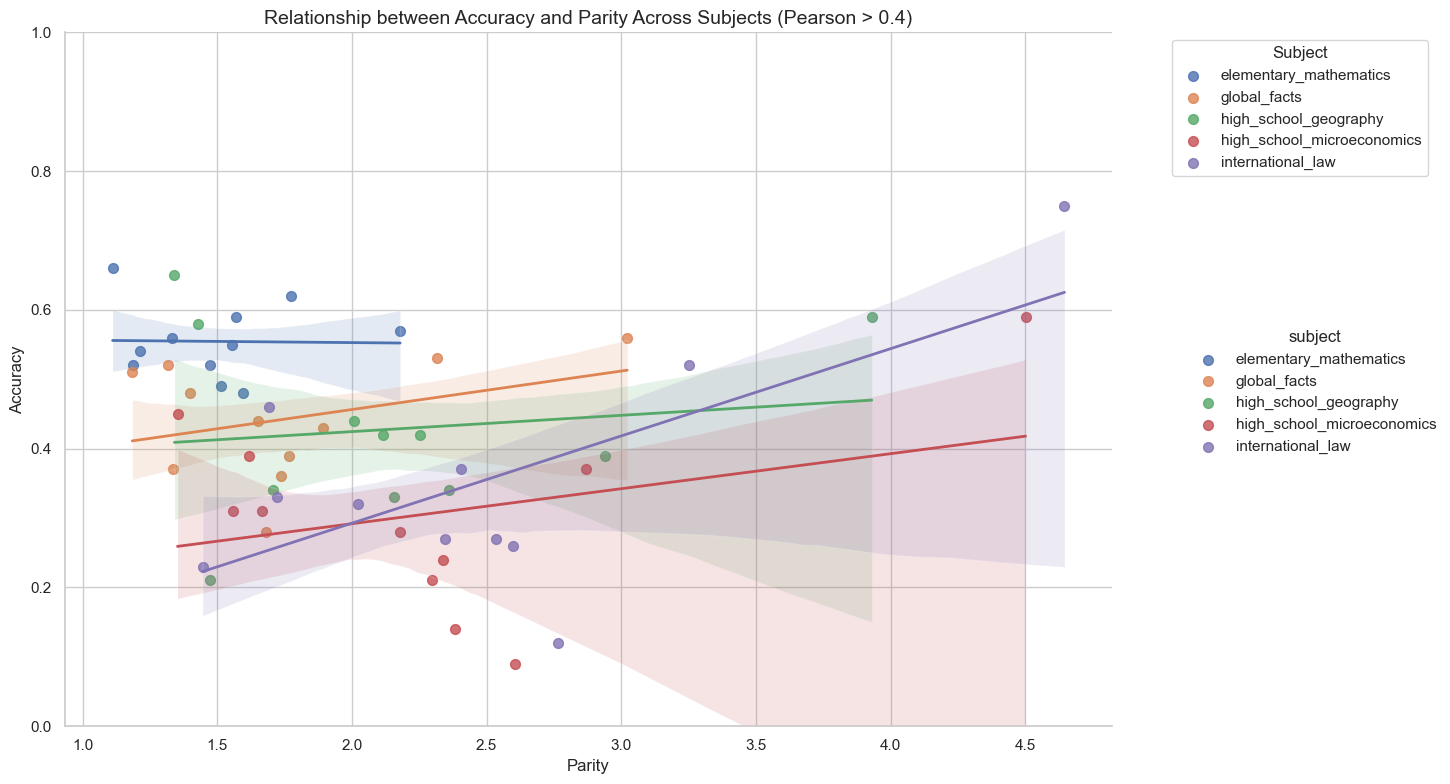

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming correlation_df contains the correlations per language
# Filter languages with Pearson correlation > 0.5
valid_languages = correlation_df[abs(correlation_df['correlation']) > 0.4].index

# Filter the original aggregated_df to include only the valid languages
filtered_df = aggregated_df_parity[aggregated_df_parity['language'].isin(valid_languages)]

# Set up the plot
plt.figure(figsize=(12, 8))
sns.set_theme(style="whitegrid")

# Create the scatterplot with regression lines for each subject
g = sns.lmplot(
    data=filtered_df,  # Use the filtered dataframe
    x="mean_parity",
    y="mean_accuracy",
    hue="subject",
    height=8,
    aspect=1.5,
    scatter_kws={"s": 50},
    line_kws={"linewidth": 2},
    ci=80,
)

# Customize the plot
plt.title("Relationship between Accuracy and Parity Across Subjects (Pearson > 0.4)", fontsize=14)
plt.xlabel("Parity", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.ylim(0,1)
# Adjust legend
plt.legend(title="Subject", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

# Show the plot
plt.show()


" This lack of tokenization parity is not merely a curiosity: it leads to unfairness in the cost to access language models, the latency of the service and the amount of data that can be processed." This affects costs, latency, and tokenization fairness.

In [48]:
print(valid_languages)

Index(['amh', 'fra', 'hau', 'ibo', 'kin', 'lug', 'orm', 'sot', 'twi', 'wol',
       'yor'],
      dtype='object')


In [15]:
aggregated_df = combined_df.groupby(['language']).agg(
    mean_accuracy=('accuracy', 'mean'),
    mean_fertility=('fertility', 'mean')
).reset_index()

# Display the aggregated DataFrame
(aggregated_df)

,language,mean_accuracy,mean_fertility
0,amh,0.612,5.886921
1,eng,0.678,1.683511
2,ewe,0.358,3.591804
3,fra,0.500,2.132617
4,hau,0.402,2.670971
5,ibo,0.396,3.246577
6,kin,0.326,3.315737
7,lin,0.470,2.226474
8,lug,0.286,3.570726
9,orm,0.374,3.465264


Considering both intrinsic and extrinsic evaluation metrics should provide a more comprehensive understanding of a tokenizer's effectiveness and its suitability for specific applications. Should look into that